In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima import auto_arima
from CommonFunctions import *
%matplotlib inline

## Import the data

In [3]:
dataset = pd.read_csv('monthly_in_situ_co2_mlo.csv', 
                      comment='"', na_values='-99.99', header=[0])
cols = []
for col1, col2, col3 in zip(dataset.columns.values, dataset.iloc[0].values, dataset.iloc[1].values):
    column_name = col1.replace(' ', '')
    for col in [str(c).replace(' ', '') for c in [col2, col3]]:
        column_name += f'_{col}' if col not in ['', 'nan'] else ''
    cols.append(column_name)
dataset = dataset.set_axis(cols, axis=1).iloc[2:].reset_index(drop=True)
dataset.Date = dataset.Yr + '-' + dataset.Mn.apply(lambda x: x.replace(' ', '')).values
dataset.index = pd.to_datetime(dataset.Date, format='%Y-%m')
dataset = dataset['CO2_filled_[ppm]']
dataset.rename('CO2', inplace=True)
dataset = dataset.apply(lambda x: float(x.replace(' ', '')))
dataset.replace(to_replace=-99.99, value=float('nan'), inplace=True)
dataset.interpolate(method='linear', axis=0, inplace=True)
dataset = dataset.iloc[2:]
dataset

Date
1958-03-01    315.71
1958-04-01    317.45
1958-05-01    317.51
1958-06-01    317.27
1958-07-01    315.87
               ...  
2024-08-01    425.22
2024-09-01    425.22
2024-10-01    425.22
2024-11-01    425.22
2024-12-01    425.22
Name: CO2, Length: 802, dtype: float64

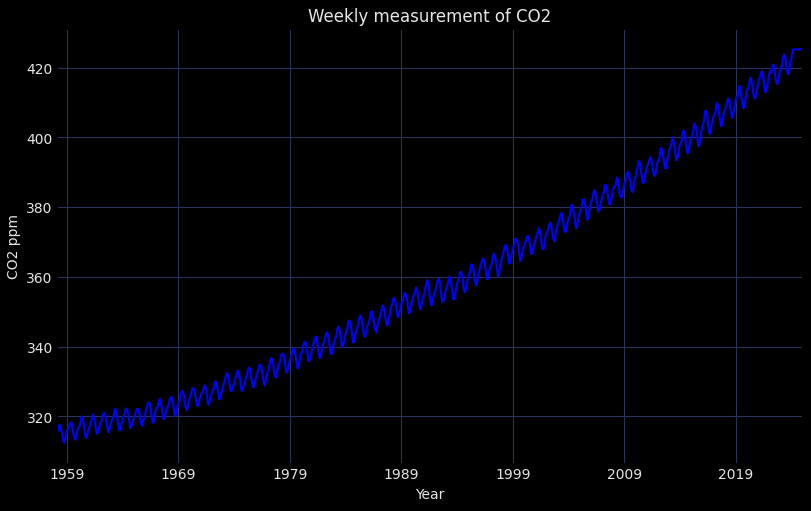

In [4]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    dataset.plot(ax=axes, color='blue')
    axes.set(title='Weekly measurement of CO2', xlabel='Year', ylabel='CO2 ppm')
    enhance_plot(figure, axes)
    figure.savefig('images/Emissions1.png')

## Split the data

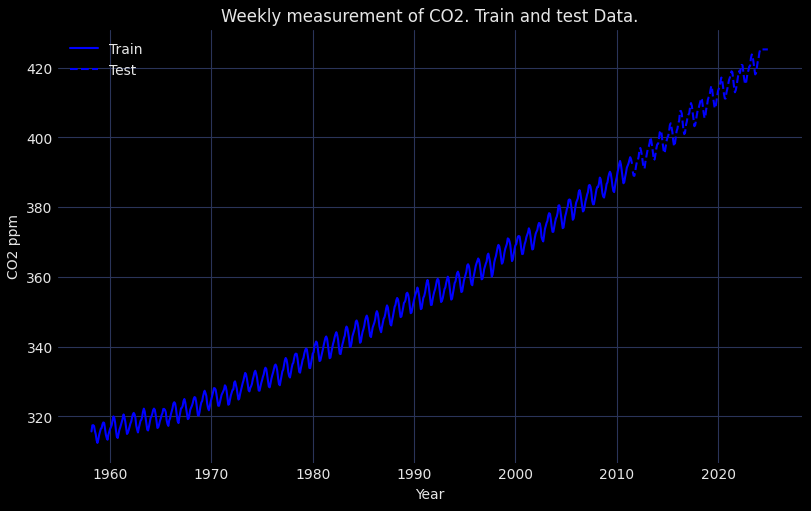

In [5]:
split_ratio = 0.8
split_part = int(len(dataset) * split_ratio)
data_train = dataset.iloc[:split_part]
data_test = dataset.iloc[split_part:]

with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    axes.plot(data_train, color='blue', label='Train')
    axes.plot(data_test, color='blue', label='Test', linestyle='--')
    axes.set(title='Weekly measurement of CO2. Train and test Data.', xlabel='Year', ylabel='CO2 ppm')
    axes.legend()
    enhance_plot(figure, axes)
    figure.savefig('images/Emissions2.png')

## Holt-Winters Prediction

In [6]:
holtWinterModel = ExponentialSmoothing(data_train, trend='add', seasonal='add', seasonal_periods=12, freq='MS').fit()
holtWinterPrediction = holtWinterModel.forecast(len(data_test)).rename('PREDICT')

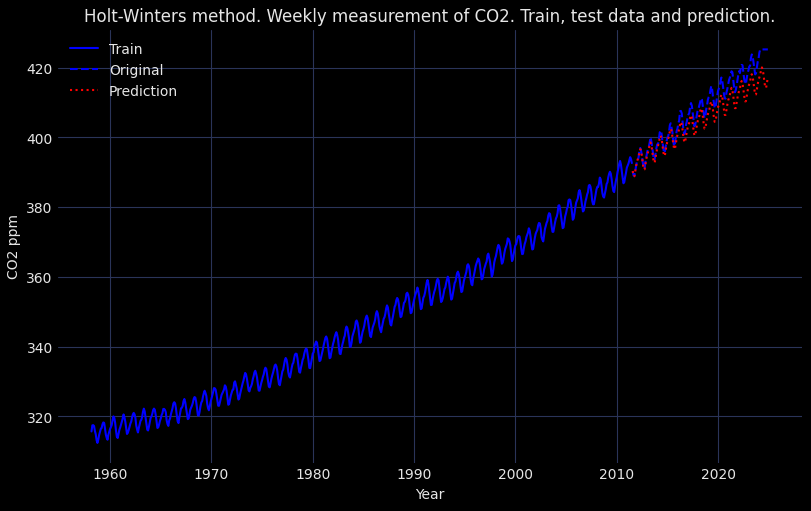

In [7]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    axes.plot(data_train, color='blue', label='Train')
    axes.plot(data_test, color='blue', label='Original', linestyle='--')
    axes.plot(holtWinterPrediction, color='red', label='Prediction', linestyle=':')
    axes.legend()
    axes.set(title='Holt-Winters method. Weekly measurement of CO2. '
                   'Train, test data and prediction.', xlabel='Year', ylabel='CO2 ppm')
    enhance_plot(figure, axes)
    figure.savefig('images/Emissions3.png')

## SARIMA Prediction

In [8]:
auto_arima(data_train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=396.885, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2075.371, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1381.815, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2079.548, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=622.157, Time=1.52 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=401.806, Time=3.87 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=427.319, Time=3.78 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1254.736, Time=0.44 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=3.46 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=487.755, Time=3.63 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=390.202, Time=4.36 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=337.222, Time=3.96 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AI

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [9]:
SARIMAmodel = SARIMAX(data_train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), freq='MS')
SARIMAprediction = (SARIMAmodel.fit().
                    predict(start := len(data_train), start + len(data_test) - 1).rename('SARIMA'))

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


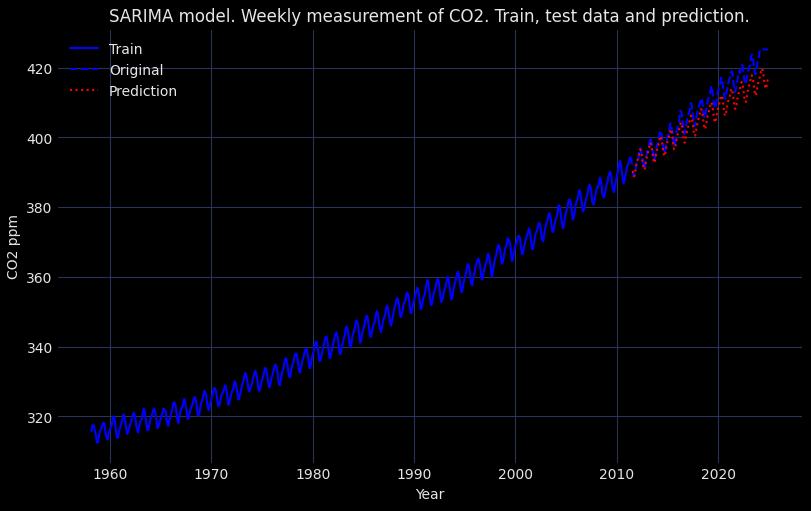

In [10]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    axes.plot(data_train, color='blue', label='Train')
    axes.plot(data_test, color='blue', label='Original', linestyle='--')
    axes.plot(SARIMAprediction, color='red', label='Prediction', linestyle=':')
    axes.legend()
    axes.set(title='SARIMA model. Weekly measurement of CO2. '
                   'Train, test data and prediction.', xlabel='Year', ylabel='CO2 ppm')
    enhance_plot(figure, axes)
    figure.savefig('images/Emissions4.png')

## Comparison

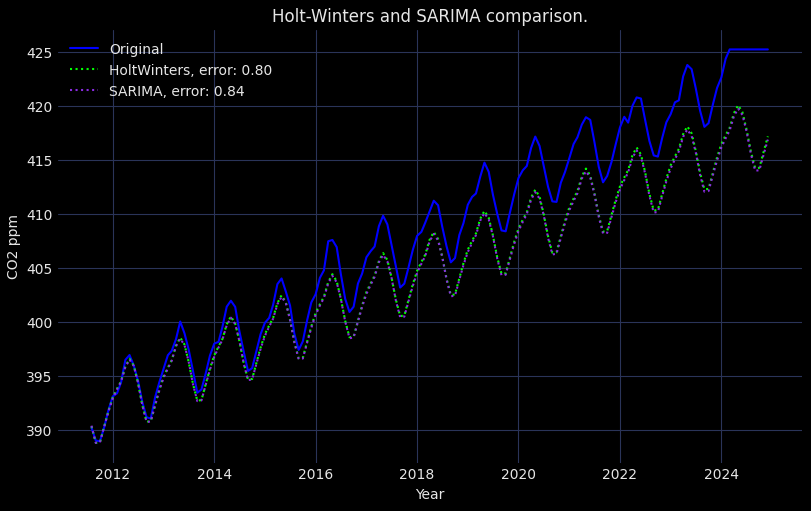

In [11]:
err_hw = mean_absolute_percentage_error(data_test, holtWinterPrediction) * 100
err_sa = mean_absolute_percentage_error(data_test, SARIMAprediction) * 100
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    axes.plot(data_test, color='blue', label='Original')
    axes.plot(holtWinterPrediction, color='lime', label=f'HoltWinters, error: {err_hw:.2f}', linestyle=':')
    axes.plot(SARIMAprediction, color='blueviolet', label=f'SARIMA, error: {err_sa:.2f}', linestyle=':')
    axes.legend()
    axes.set(title='Holt-Winters and SARIMA comparison.', xlabel='Year', ylabel='CO2 ppm')
    enhance_plot(figure, axes)
    figure.savefig('images/Emissions5.png')

We can see that predictions are almost identical.